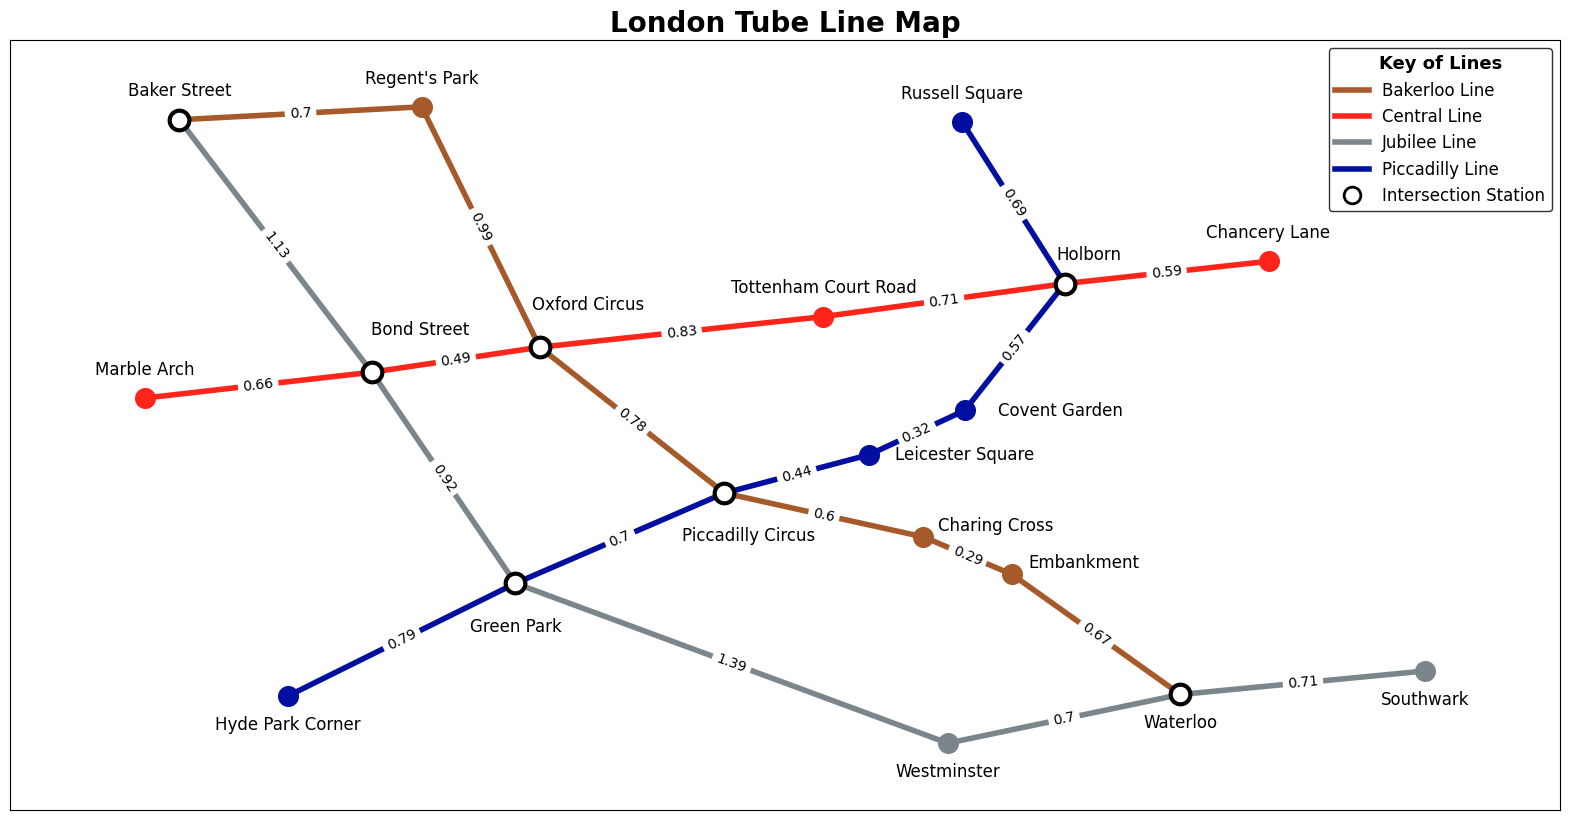

Total length of the transport network: 15.67 km
Average distance between stations: 0.71 km
Standard deviation of distances between stations: 0.25 km


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------- Data Loading -------------------
# Load the station data
stations_file_path = 'London stations.csv'
stations_data = pd.read_csv(stations_file_path)
stations_data.columns = stations_data.columns.str.strip()

# Load the line color data
color_file_path = 'Line color.csv'
color_data = pd.read_csv(color_file_path)
color_data.columns = color_data.columns.str.strip()

# ------------------- Corlor Convert Function -------------------
# Convert RGB to HEX in the color mapping
def rgb_to_hex(r, g, b):
    return f'#{r:02x}{g:02x}{b:02x}'

color_data['HexColor'] = color_data.apply(
    lambda row: rgb_to_hex(row['ColorR'], row['ColorG'], row['ColorB']), axis=1
)

# Create a dictionary for line colors
color_mapping = dict(zip(color_data['Line'], color_data['HexColor']))

# ------------------- Haversine Function -------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ------------------- Graph Data Preparation -------------------
bakerloo_line_edges = [
    ("Waterloo", "Embankment"),
    ("Embankment", "Charing Cross"),
    ("Charing Cross", "Piccadilly Circus"),
    ("Piccadilly Circus", "Oxford Circus"),
    ("Oxford Circus", "Regent's Park"),
    ("Regent's Park", "Baker Street")
]

central_line_edges = [
    ("Marble Arch", "Bond Street"),
    ("Bond Street", "Oxford Circus"),
    ("Oxford Circus", "Tottenham Court Road"),
    ("Tottenham Court Road", "Holborn"),
    ("Holborn", "Chancery Lane")
]

jubilee_line_edges = [
    ("Baker Street", "Bond Street"),
    ("Bond Street", "Green Park"),
    ("Green Park", "Westminster"),
    ("Westminster", "Waterloo"),
    ("Waterloo", "Southwark")
]

piccadilly_line_edges = [
    ("Hyde Park Corner", "Green Park"),
    ("Green Park", "Piccadilly Circus"),
    ("Piccadilly Circus", "Leicester Square"),
    ("Leicester Square", "Covent Garden"),
    ("Covent Garden", "Holborn"),
    ("Holborn", "Russell Square"),
]

edges = []
edge_labels = {}

# Adding line edges with distances and colors
for edge_list, line_name in [
    (bakerloo_line_edges, 'Bakerloo'),
    (central_line_edges, 'Central'),
    (jubilee_line_edges, 'Jubilee'),
    (piccadilly_line_edges, 'Piccadilly'),
    ]:
    line_color = color_mapping.get(line_name, '#000000')  # Default to black if color not found
    for edge in edge_list:
        station1 = stations_data[stations_data['Station'] == edge[0]].iloc[0]
        station2 = stations_data[stations_data['Station'] == edge[1]].iloc[0]
        distance = haversine(station1['Latitude'], station1['Longitude'],
                             station2['Latitude'], station2['Longitude'])
        edges.append((edge[0], edge[1], round(distance, 2), line_color))
        edge_labels[(edge[0], edge[1])] = f"{round(distance, 2)}"

G = nx.Graph()
for _, row in stations_data.iterrows():
    G.add_node(row['Station'], pos=(row['Longitude'], row['Latitude']))

for edge in edges:
    G.add_edge(edge[0], edge[1], color=edge[3], weight=edge[2])

stations_by_line = {
    'Bakerloo': set(station for edge in bakerloo_line_edges for station in edge),
    'Central': set(station for edge in central_line_edges for station in edge),
    'Jubilee': set(station for edge in jubilee_line_edges for station in edge),
    'Piccadilly': set(station for edge in piccadilly_line_edges for station in edge),
}

intersection_stations = set()
for station in G.nodes():
    line_count = sum(station in stations_by_line[line] for line in stations_by_line)
    if line_count >= 2:
        intersection_stations.add(station)

node_colors = {}
for node in G.nodes():
    if node in intersection_stations:
        node_colors[node] = '#ffffff'
    elif node in stations_by_line['Bakerloo']:
        node_colors[node] = color_mapping['Bakerloo']
    elif node in stations_by_line['Central']:
        node_colors[node] = color_mapping['Central']
    elif node in stations_by_line['Jubilee']:
        node_colors[node] = color_mapping['Jubilee']
    elif node in stations_by_line['Piccadilly']:
        node_colors[node] = color_mapping['Piccadilly']

G_filtered = G.subgraph(node_colors.keys())
positions = nx.get_node_attributes(G_filtered, 'pos')

# ------------------- Adjust labels based on initial positions -------------------
label_pos_adjustments = {
    "Baker Street": (positions["Baker Street"][0], positions["Baker Street"][1] + 0.001),
    "Bond Street": (positions["Bond Street"][0] + 0.002, positions["Bond Street"][1] + 0.0015),
    "Chancery Lane": (positions["Chancery Lane"][0], positions["Chancery Lane"][1] + 0.001),
    "Charing Cross": (positions["Charing Cross"][0] + 0.003, positions["Charing Cross"][1] + 0.0004),
    "Covent Garden": (positions["Covent Garden"][0] + 0.004, positions["Covent Garden"][1]),
    "Embankment": (positions["Embankment"][0] + 0.003, positions["Embankment"][1] + 0.0004),
    "Green Park": (positions["Green Park"][0], positions["Green Park"][1] - 0.0015),
    "Holborn": (positions["Holborn"][0] + 0.001, positions["Holborn"][1] + 0.001),
    "Hyde Park Corner": (positions["Hyde Park Corner"][0], positions["Hyde Park Corner"][1] - 0.001),
    "Leicester Square": (positions["Leicester Square"][0] + 0.004, positions["Leicester Square"][1]),
    "Marble Arch": (positions["Marble Arch"][0], positions["Marble Arch"][1] + 0.001),
    "Oxford Circus": (positions["Oxford Circus"][0] + 0.002, positions["Oxford Circus"][1] + 0.0015),
    "Piccadilly Circus": (positions["Piccadilly Circus"][0] + 0.001, positions["Piccadilly Circus"][1] - 0.0015),
    "Regent's Park": (positions["Regent's Park"][0], positions["Regent's Park"][1] + 0.001),
    "Russell Square": (positions["Russell Square"][0], positions["Russell Square"][1] + 0.001),
    "Tottenham Court Road": (positions["Tottenham Court Road"][0], positions["Tottenham Court Road"][1] + 0.001),
    "Southwark": (positions["Southwark"][0], positions["Southwark"][1] - 0.001),
    "Waterloo": (positions["Waterloo"][0], positions["Waterloo"][1] - 0.001),
    "Westminster": (positions["Westminster"][0], positions["Westminster"][1] - 0.001),
}

# ------------------- Graph Visualization -------------------
plt.figure(figsize=(20, 10))

# Draw non-intersection nodes
for node in G_filtered.nodes():
    if node not in intersection_stations:
        nx.draw_networkx_nodes(
            G_filtered,
            pos=positions,
            nodelist=[node],
            node_size=200,
            node_color=node_colors[node]
        )

# Draw intersection nodes
for node in intersection_stations:
    x, y = positions[node]
    plt.scatter(x, y, s=200, color='#ffffff', edgecolor='#000000', linewidth=3, zorder=3)

edge_colors = [G_filtered[u][v]['color'] for u, v in G_filtered.edges()]
nx.draw_networkx_edges(
    G_filtered,
    pos=positions,
    edge_color=edge_colors,
    width=4
)

nx.draw_networkx_labels(G_filtered, pos=label_pos_adjustments, font_size=12)
nx.draw_networkx_edge_labels(
    G_filtered,
    pos=positions,
    edge_labels=edge_labels,
    font_size=10,
)

legend_elements = [
    plt.Line2D([0], [0], color=color_mapping['Bakerloo'], lw=4, label='Bakerloo Line'),
    plt.Line2D([0], [0], color=color_mapping['Central'], lw=4, label='Central Line'),
    plt.Line2D([0], [0], color=color_mapping['Jubilee'], lw=4, label='Jubilee Line'),
    plt.Line2D([0], [0], color=color_mapping['Piccadilly'], lw=4, label='Piccadilly Line'),
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='#ffffff', 
               markeredgecolor='#000000', markersize=12, markeredgewidth=2, label='Intersection Station')
]

legend = plt.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True, title="Key of Lines")
legend.get_frame().set_edgecolor('#000000')  # Black border for the legend box
legend.get_frame().set_linewidth(1)        # Adjust border thickness
legend.get_title().set_fontsize('13')        # Font size for "Key" title
legend.get_title().set_fontweight('bold')    # Make "Key" title bold

plt.title("London Tube Line Map", fontsize=20, fontweight='bold')
plt.show()

# ------------------- Distance Statistics -------------------
edges_data = pd.DataFrame(edges, columns=['Station1', 'Station2', 'Distance', 'LineColor'])

total_length = round(edges_data['Distance'].sum(), 2)
average_distance = round(edges_data['Distance'].mean(), 2)
std_distance = round(edges_data['Distance'].std(), 2)

print("Total length of the transport network:", total_length, "km")
print("Average distance between stations:", average_distance, "km")
print("Standard deviation of distances between stations:", std_distance, "km")

